Re-tune photometry parameters again because there are too many mismatched and / or missed stars.

In [35]:
cd /orange/adamginsburg/jwst/brick/

/blue/adamginsburg/adamginsburg/jwst/brick


In [19]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [20]:
from astropy import coordinates

In [21]:
import numpy as np

In [22]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry


/scratch/local/27325759/ipykernel_4169643/3909488129.py:1: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/27325759/ipykernel_4169643/3909488129.py:1: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed in the future. Instead, please use `from photutils.psf import EPSFBuilder` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/27325759/ipykernel_4169643/3909488129.py:1: DeprecationWarning: `photutils.find_peaks` is a deprecated alias for `photutils.detection.find_peaks` and will be removed in the future. Instead, please use `from photutils.detection import find_p

In [23]:
import warnings

In [24]:
import regions

In [25]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [26]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [27]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100
pl.rcParams['font.size'] = 16

In [28]:
import glob
from astropy.io import fits

In [29]:
filternames = ['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [30]:
imgfns = [x
          for filn in filternames
          for x in glob.glob(f"{basepath}/{filn.upper()}/pipeline/jw02221-o001_t001_nircam*{filn.lower()}*nrca_i2d.fits")
          if 'nrca_' in x or 'nrca1_' in x
         ]

print(" ".join(imgfns))
imgfns

/orange/adamginsburg/jwst/brick//F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca_i2d.fits


['/orange/adamginsburg/jwst/brick//F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca_i2d.fits']

In [31]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    #wcses = [wcs.WCS(fits.getheader(fn.replace("_crowdsource", "_crowdsource_skymodel"))) for fn in catfns]
    imgs = [fits.getdata(fn, ext=('SCI', 1)) for fn in imgfns]
    wcses = [wcs.WCS(fits.getheader(fn, ext=('SCI', 1))) for fn in imgfns]
    desat='_unsatstar'
    module='nrca'
    tbls = [Table.read(f"{basepath}/{filtername.upper()}/{filtername.lower()}_{module}{desat}_crowdsource_nsky0.fits")
            for filtername in filternames]
    # tbls_daob = [Table.read(f"{basepath}/{filtername.upper()}/{filtername.lower()}_{module}{desat}_daophot_basic.fits")
    #         for filtername in filternames]
    # tbls_daop = [Table.read(f"{basepath}/{filtername.upper()}/{filtername.lower()}_{module}{desat}_daophot_iterative.fits")
    #         for filtername in filternames]
    basetable = Table.read(f'{basepath}/catalogs/crowdsource_nsky0_nrca_photometry_tables_merged.fits')

In [32]:
basepath = '/orange/adamginsburg/jwst/brick/'
reg = regions.Regions.read(f'{basepath}/regions_/leftside_brick_zoom.reg')[0]
regzoom = regions.Regions.read(f'{basepath}/regions_/leftside_brick_rezoom.reg')[0]

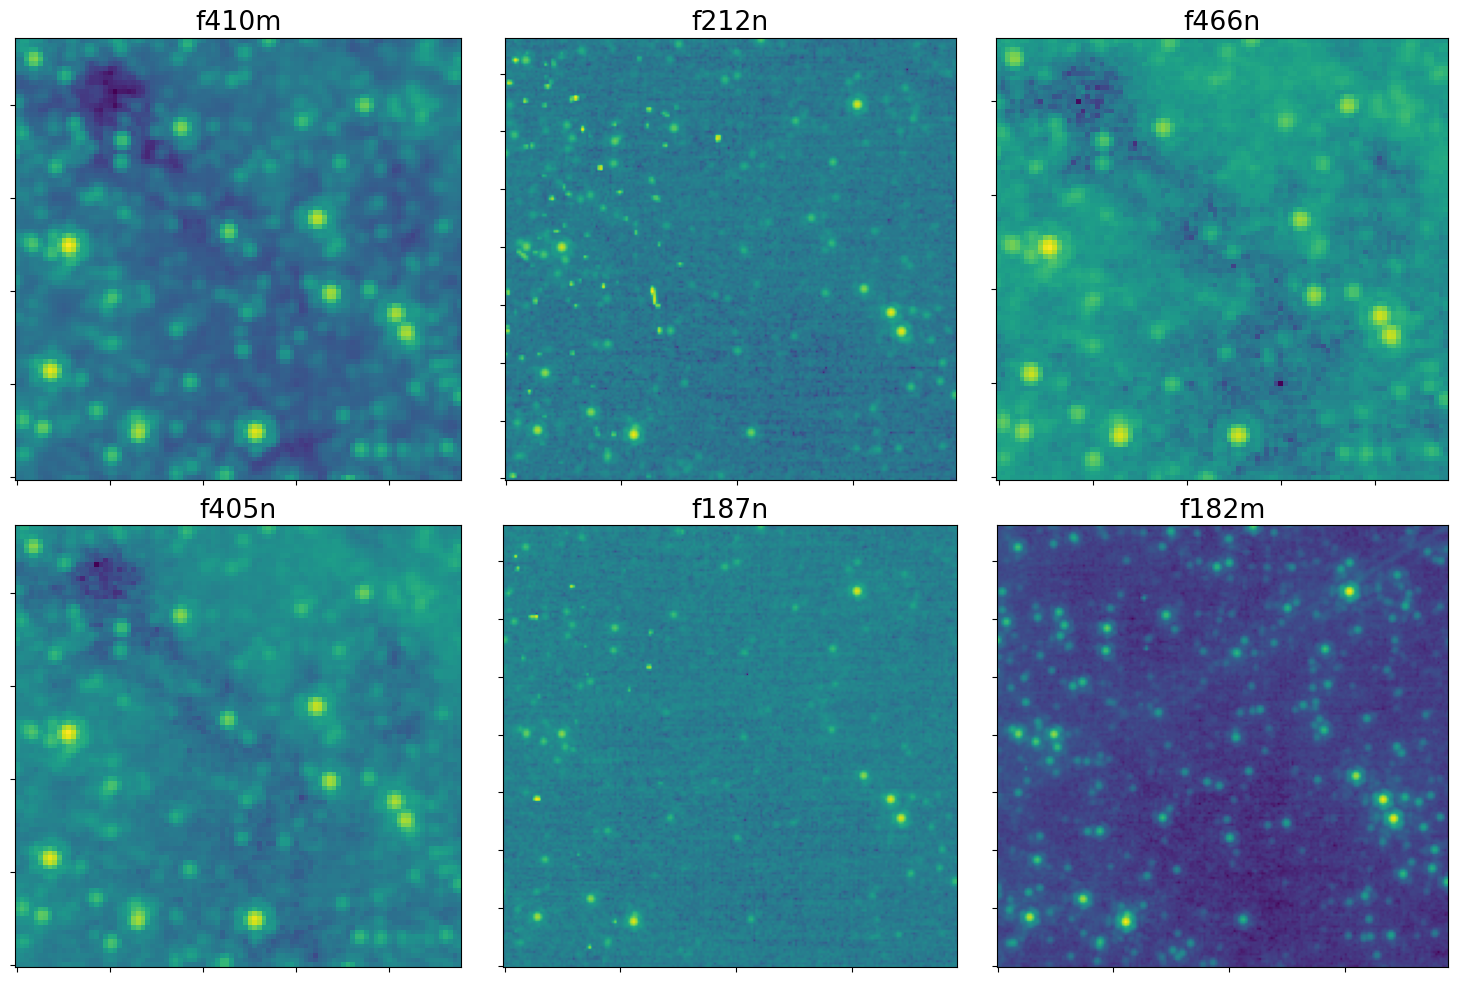

In [33]:
pl.figure(figsize=(15,10))
for ii, (img, ww, filt) in enumerate(zip(imgs, wcses, filternames)):
    ax = pl.subplot(2, 3, ii+1)
    mask = regzoom.to_pixel(ww).to_mask()
    slcs,_ = mask.get_overlap_slices(img.shape[:2])
    co = img[slcs[0], slcs[1], ]

    ax.imshow(co, norm=simple_norm(co, stretch='log'))
    ax.set_title(filt)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
pl.tight_layout();

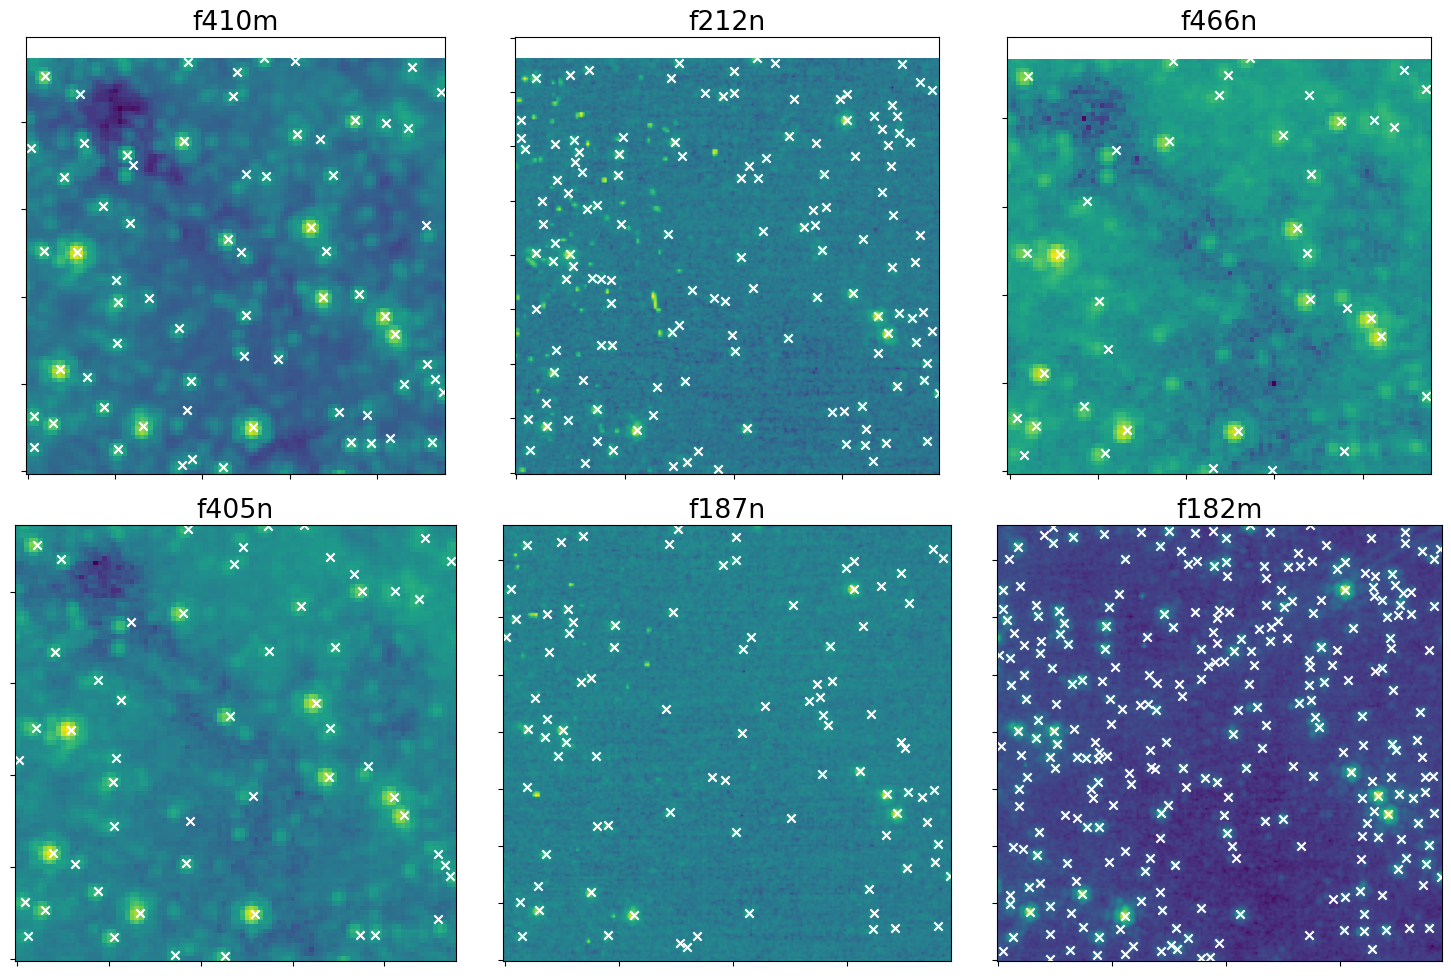

In [34]:
pl.figure(figsize=(15,10))
for ii, (img, ww, filt, tb) in enumerate(zip(imgs, wcses, filternames, tbls)):
    ax = pl.subplot(2, 3, ii+1)
    mask = regzoom.to_pixel(ww).to_mask()
    slcs,_ = mask.get_overlap_slices(img.shape[:2])
    co = img[slcs[0], slcs[1], ]
    crds = tb['skycoord']
    crds = crds[ww[slcs].footprint_contains(crds)]
    xx, yy = ww[slcs].world_to_pixel(crds)

    ax.imshow(co, norm=simple_norm(co, stretch='log'))
    ax.scatter(xx, yy, color='w', marker='x')
    ax.set_title(filt)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
pl.tight_layout();